### Problem Statement

As a data Scientist working for a financial advisory company, we have been tasked to classify investors who require basic savings/investment plans from higher net worth individuals who prefer higher growth investment plans. 

Through comparing 2 different subreddits that are reflective of such financially challenged or risky high net worth individuals, we aim to build a classification model and deploy on other forums so that our financial advisors can reach out to individuals with a suitable financial plan. This will thus result in greater conversion rate and more profits for the company. The subreddits that we will be choosing are r/wallstreetbets for investors looking for higher risk high growth plans and r/povertyfinance for investors who are better suited for a basic savings/investment plan.

## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime as dt
from dateutil.parser import *
import random
import time
import json
from numpy import argmax
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score,classification_report, roc_auc_score,accuracy_score, \
precision_score, f1_score, recall_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)

pd.options.display.float_format = '{:.3f}'.format

In [2]:
wsb_df = pd.read_csv('./datasets/wallstreetbets_df.csv')
pfin_df = pd.read_csv('./datasets/pfinance_df.csv')

In [3]:
display(wsb_df.info())
display(pfin_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10020 entries, 0 to 10019
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  10020 non-null  object 
 1   allow_live_comments            10020 non-null  bool   
 2   author                         10020 non-null  object 
 3   author_flair_css_class         3 non-null      object 
 4   author_flair_richtext          9985 non-null   object 
 5   author_flair_text              1008 non-null   object 
 6   author_flair_type              9985 non-null   object 
 7   author_fullname                9985 non-null   object 
 8   author_is_blocked              10020 non-null  bool   
 9   author_patreon_flair           9985 non-null   object 
 10  author_premium                 9985 non-null   object 
 11  awarders                       10020 non-null  object 
 12  can_mod_post                   10020 non-null 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10017 entries, 0 to 10016
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   all_awardings                  10017 non-null  object 
 1   allow_live_comments            10017 non-null  bool   
 2   author                         10017 non-null  object 
 3   author_flair_css_class         9 non-null      object 
 4   author_flair_richtext          9956 non-null   object 
 5   author_flair_text              49 non-null     object 
 6   author_flair_type              9956 non-null   object 
 7   author_fullname                9956 non-null   object 
 8   author_is_blocked              8422 non-null   object 
 9   author_patreon_flair           9956 non-null   object 
 10  author_premium                 9956 non-null   object 
 11  awarders                       10017 non-null  object 
 12  can_mod_post                   10017 non-null 

None

### Analysis

On inspection, we see that there is a mix of different dtypes. The two most important columns, 'selftext' and 'title' are strings. We also take note of numerical columns such as number of comments or upvote ratio which we may use later for analysis and model building.

In [4]:
#checking for null values
pfin_df.isna().sum()

all_awardings                        0
allow_live_comments                  0
author                               0
author_flair_css_class           10008
author_flair_richtext               61
author_flair_text                 9968
author_flair_type                   61
author_fullname                     61
author_is_blocked                 1595
author_patreon_flair                61
author_premium                      61
awarders                             0
can_mod_post                         0
contest_mode                         0
created_utc                          0
domain                               0
full_link                            0
gildings                             0
id                                   0
is_created_from_ads_ui             129
is_crosspostable                     0
is_meta                              0
is_original_content                  0
is_reddit_media_domain               0
is_robot_indexable                   0
is_self                  

In [5]:
wsb_df.isna().sum()

all_awardings                        0
allow_live_comments                  0
author                               0
author_flair_css_class           10017
author_flair_richtext               35
author_flair_text                 9012
author_flair_type                   35
author_fullname                     35
author_is_blocked                    0
author_patreon_flair                35
author_premium                      35
awarders                             0
can_mod_post                         0
contest_mode                         0
created_utc                          0
domain                               0
full_link                            0
gildings                             0
id                                   0
is_created_from_ads_ui               0
is_crosspostable                     0
is_meta                              0
is_original_content                  0
is_reddit_media_domain               0
is_robot_indexable                   0
is_self                  

### Analysis

We see that both datasets indeed have na values. Let's check the titles of the selftext, which is the column that we will be doing most of our evaluation, to see why this is the case.

In [6]:
pfin_na_df = pfin_df[pfin_df['selftext'].isna()]
pfin_na_df['title']

3        After hearing that Bella Hadid couldn't afford...
4                     Read the room, BankTextBot. (x-post)
26       Just a reminder to always look at the unit pri...
27       We may not have much, and we may have wrapped ...
29               SERIOUSLY??? This shouldn't even be legal
34       After years of sleeping on a twin xl, I finall...
35                 Poverty can be a barrier to employment.
37                              Feel like this belong here
38                           Poverty is one of our problem
45       Food Pantry in Brooklyn, NY. Volunteer to cont...
48       Sign up for new Kindle "FREE" books periodicly...
49       This is me the day I finally make my first $1m...
54       Mini Food Pantry - Jonesville, NC - should be ...
59       Can a company still garnish my wages if I move...
60       the system IS unfair. the company that owns th...
71       Cancelled debt due to “decision or policy to d...
72       Anyone with an android who needs extra cash sh.

In [7]:
# Checking if posts that contain video are also the ones with na in selftext

pfin_isvid_index = pfin_df[pfin_df['is_video']].index

display(pfin_df[pfin_df['is_video']].index)

Int64Index([  49,  110,  161,  227,  504,  593,  662, 2600, 2906, 3611, 3673,
            3674, 4222, 4232, 4634, 5103, 5135, 5644, 5968, 6314, 6494, 6595,
            7117, 7538, 7601, 7765, 7904, 8351, 8363, 8503, 8754, 8835, 9150,
            9200, 9474, 9880],
           dtype='int64')

In [8]:
# check if is_vid is also na in selftext
[index for index in pfin_isvid_index if index in pfin_na_df.index]


[49,
 110,
 161,
 227,
 504,
 593,
 662,
 2600,
 2906,
 3611,
 3673,
 3674,
 4222,
 4232,
 4634,
 5103,
 5135,
 5644,
 5968,
 6314,
 6494,
 6595,
 7117,
 7538,
 7601,
 7765,
 7904,
 8351,
 8363,
 8503,
 8754,
 8835,
 9150,
 9200,
 9474,
 9880]

### Analysis

Through checking the texts, we suspect that the selftexts with na values are usually those that represented their message through a picture or video. This is confirmed by the is_vid column, where we can see that many of those in is_vid had na values in selftext (if the post contians a video with is_video will be true) We went to browse the r/povertyfinance subreddit and we notice that many of these pics/vids are from people showcasing pictures of finances, credit scores and bills. Approval letters for loans, funds were also common.

In [9]:
#extracting title of the selftext with na values

wsb_na_df = wsb_df[wsb_df['selftext'].isna()]
wsb_na_df['title']

0                                         That's a Cute DD
2                           I don't wanna be broke anymore
3        Treasuretoken.finance launched yesterday to th...
5        Be careful, as individual open selling forces ...
6                                             GME shorts 😎
10                     Nikola officially has a dealership!
12                                Gamestop and AMC Holders
16                                    Yoooo the next mooon
21                                          Jetez-y un œil
22       Beats Production of semis before Tesla. I have...
26                                    Morgan Stanley Said…
27       Everyone talking about GME but I'm betting it ...
30                                     Morgan Stanley said
32       Wish appoints Todd Li as General Manager in China
33       Just woke up at 4am to make sure I could still...
35       Spotted in the wild. In a building site urinal...
36                                  Which of you was thi

### Analysis

Through inspection, we notice that apart from pics/vids, there are more memes being posted in r/wsb forum than r/povertyfinance. This is because many of the people posting on r/wsb are of a younger generation who uses memes to express themselves.

In [10]:
# fill in the nan values with an empty string, retain the title for analysis later

wsb_df['selftext'] = wsb_df['selftext'].fillna('')
pfin_df['selftext'] = pfin_df['selftext'].fillna('')

In [11]:
# Check for duplicates

wsb_df_duplicated = wsb_df[wsb_df.duplicated()]
display(wsb_df_duplicated)

pfin_df_duplicated = pfin_df[pfin_df.duplicated()]
display(pfin_df_duplicated)

Empty DataFrame
Columns: [all_awardings, allow_live_comments, author, author_flair_css_class, author_flair_richtext, author_flair_text, author_flair_type, author_fullname, author_is_blocked, author_patreon_flair, author_premium, awarders, can_mod_post, contest_mode, created_utc, domain, full_link, gildings, id, is_created_from_ads_ui, is_crosspostable, is_meta, is_original_content, is_reddit_media_domain, is_robot_indexable, is_self, is_video, link_flair_background_color, link_flair_css_class, link_flair_richtext, link_flair_template_id, link_flair_text, link_flair_text_color, link_flair_type, locked, media_only, no_follow, num_comments, num_crossposts, over_18, parent_whitelist_status, permalink, pinned, post_hint, preview, pwls, retrieved_on, score, selftext, send_replies, spoiler, stickied, subreddit, subreddit_id, subreddit_subscribers, subreddit_type, suggested_sort, thumbnail, thumbnail_height, thumbnail_width, title, total_awards_received, treatment_tags, upvote_ratio, url, url_overridden_by_dest, whitelist_status, wls, removed_by_category, is_gallery, media_metadata, author_flair_background_color, author_flair_text_color, author_flair_template_id, gallery_data, media, media_embed, secure_media, secure_media_embed, author_cakeday, live_audio, poll_data, banned_by]
Index: []

[0 rows x 83 columns]

Empty DataFrame
Columns: [all_awardings, allow_live_comments, author, author_flair_css_class, author_flair_richtext, author_flair_text, author_flair_type, author_fullname, author_is_blocked, author_patreon_flair, author_premium, awarders, can_mod_post, contest_mode, created_utc, domain, full_link, gildings, id, is_created_from_ads_ui, is_crosspostable, is_meta, is_original_content, is_reddit_media_domain, is_robot_indexable, is_self, is_video, link_flair_background_color, link_flair_richtext, link_flair_template_id, link_flair_text, link_flair_text_color, link_flair_type, locked, media_only, no_follow, num_comments, num_crossposts, over_18, parent_whitelist_status, permalink, pinned, pwls, retrieved_on, score, selftext, send_replies, spoiler, stickied, subreddit, subreddit_id, subreddit_subscribers, subreddit_type, thumbnail, title, total_awards_received, treatment_tags, upvote_ratio, url, whitelist_status, wls, media, media_embed, post_hint, preview, secure_media, secure_media_embed, thumbnail_height, thumbnail_width, url_overridden_by_dest, removed_by_category, poll_data, crosspost_parent, crosspost_parent_list, author_cakeday, author_flair_template_id, author_flair_text_color, media_metadata, author_flair_background_color, distinguished, edited, banned_by, removal_reason, gilded]
Index: []

[0 rows x 84 columns]

### Analysis

We observe that there are no duplicated entries

In [12]:
# Another check for duplicates if text and title is the same
print(len(wsb_df[(wsb_df.duplicated(subset=['selftext','title'],keep='first'))]))
print(len(pfin_df[(pfin_df.duplicated(subset=['selftext','title'],keep='first'))]))

421
136


In [13]:
# We drop these duplicates as they do not convey additional information
wsb_df.drop(wsb_df[(wsb_df.duplicated(subset=['selftext','title'],keep='first'))].index,inplace=True)
pfin_df.drop(pfin_df[(pfin_df.duplicated(subset=['selftext','title'],keep='first'))].index,inplace=True)
display(len(wsb_df))
display(len(pfin_df))

9599

9881

In [14]:
# Combine selftext and title columns into a new column

wsb_df['new_text'] = wsb_df['selftext'] +' '+ wsb_df['title']
pfin_df['new_text'] = pfin_df['selftext'] +' '+ pfin_df['title']

In [15]:
#combining the 2 dfs for further cleaning with regex

combined_df = pd.concat([wsb_df,pfin_df])
combined_df.reset_index(inplace=True,drop=True)

combined_df['new_text'] = combined_df['new_text'].str.lower() # changing all to lower case
combined_df.head()

all_awardings  allow_live_comments       author author_flair_css_class  \
0            []                False  Eurymanthus                    NaN   
1            []                False      roxredd                    NaN   
2            []                False  Some-rando_                    NaN   
3            []                False      gsm1022                    NaN   
4            []                False      gsm1022                    NaN   

  author_flair_richtext author_flair_text author_flair_type author_fullname  \
0                    []               NaN              text     t2_h8m31j98   
1                    []               NaN              text     t2_4a5t4q0e   
2                    []               NaN              text     t2_if6zz3kt   
3                    []               NaN              text     t2_6exlq346   
4                    []               NaN              text     t2_6exlq346   

  author_is_blocked author_patreon_flair  ... live_audio poll_data  banned_by  \
0             False                False  ...        NaN       NaN        NaN   
1             False                False  ...        NaN       NaN        NaN   
2             False                False  ...        NaN       NaN        NaN   
3             False                False  ...        NaN       NaN        NaN   
4             False                False  ...        NaN       NaN        NaN   

                                            new_text  crosspost_parent  \
0                                   that's a cute dd               NaN   
1  you buy a stock at a cheap price, the price go...               NaN   
2                     i don't wanna be broke anymore               NaN   
3   treasuretoken.finance launched yesterday to t...               NaN   
4  [removed] treasuretoken.finance launched yeste...               NaN   

  crosspost_parent_list distinguished edited removal_reason gilded  
0                   NaN           NaN    NaN            NaN    NaN  
1                   NaN           NaN    NaN            NaN    NaN  
2                   NaN           NaN    NaN            NaN    NaN  
3                   NaN           NaN    NaN            NaN    NaN  
4                   NaN           NaN    NaN            NaN    NaN  

[5 rows x 90 columns]

In [16]:
# remove hyperlinks and words asking people to click on hyperlink
display(combined_df['new_text'].str.extract('(www\S+)').value_counts())
display(combined_df['new_text'].str.extract('(http\S+)').value_counts())
display(combined_df['new_text'].str.extract('(click)').value_counts())

combined_df['new_text'] = combined_df['new_text'].str.replace(r'(http\S+)','')
combined_df['new_text'] = combined_df['new_text'].str.replace(r'(www\S+)','')
combined_df['new_text'] = combined_df['new_text'].str.replace(r'(click)','')

www.reddit.com/r/wallstreetbets/wiki/contentguide),                                                                                                                                                                                                                                                                                                                                                            31
www.bestapp.com/best-shopping-apps/                                                                                                                                                                                                                                                                                                                                                                             3
www.statista.com/statistics/282087/number-of-monthly-active-twitter-users/#:\~:text=as%20of%20the%20first%20quarter,daily%20active%20users%20(mdau)](https://www.statista.com/statistics/282087/numb

https://www.reddit.com/r/wallstreetbets/wiki/contentguide),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        31
https://money.yahoo.com/video/houghton-mifflin-activist-investor-veritas-145404487.html)                                                                                                                                                                                                                                                                                          

click    107
dtype: int64

In [17]:
# check if removed hyperlinks
display(combined_df['new_text'].str.extract('(www\S+)').value_counts())
display(combined_df['new_text'].str.extract('(http\S+)').value_counts())
display(combined_df['new_text'].str.extract('(click)').value_counts())

Series([], dtype: int64)

Series([], dtype: int64)

Series([], dtype: int64)

In [18]:
#removing unicode caharcter
combined_df['new_text'].str.extract(r'(&amp;#x200b)').value_counts()
combined_df['new_text'] = combined_df['new_text'].str.replace(r'(&amp;#x200b)','')

In [19]:
#checking no unicode caharcter
display(combined_df['new_text'].str.extract(r'(&amp;#x200b)').value_counts())

Series([], dtype: int64)

In [20]:
#removing numerical digits
display(combined_df['new_text'].str.extract(r'(\d+)').value_counts().head())
combined_df['new_text'] = combined_df['new_text'].str.replace('\d+','')

2     627
1     580
3     507
5     398
10    394
dtype: int64

In [21]:
# check if removed numerical digits
display(combined_df['new_text'].str.extract(r'(\d+)').value_counts().head())

Series([], dtype: int64)

In [22]:
#remove standalone single letters
combined_df['new_text'] = combined_df['new_text'].str.replace(r'\b\w\b','')

In [23]:
#check if removed single letters
combined_df['new_text'].str.extract('(\b\w\b)').value_counts().head()

Series([], dtype: int64)

In [24]:
# removing punctuation and emoticon
display(combined_df['new_text'].str.extract(r'([^\w\s])').value_counts())
display(combined_df['new_text'].str.extract(r'(_)').value_counts())

combined_df['new_text'] = combined_df['new_text'].str.replace(r'([^\w\s])','')
combined_df['new_text'] = combined_df['new_text'].str.replace('_',' ')

[    3582
.    3398
,    2837
'    1526
’    1298
?     968
$     800
!     635
-     480
:     417
(     412
/     280
"     130
*     128
…     123
%     118
;     114
&      94
“      74
🚀      55
#      45
+      33
|      25
@      17
🦍      15
~      15
💎      13
—      13
‘      12
🤔      12
😂      12
£      10
😎       9
=       9
€       7
😏       7
🌈       6
🤣       5
👀       5
💀       5
👋       5
\       4
💪       4
🔥       4
–       4
🐻       4
👍       4
💥       4
💰       4
🍿       3
     ... 
🌙       1
🌋       1
‎       1
🆘       1
🅿       1
🅱       1
✌       1
✅       1
⚡       1
⚠       1
☺       1
☮       1
☢       1
☠       1
☆       1
⁉       1
‼       1
🎶       1
🏋       1
🏦       1
👥       1
🔴       1
🔝       1
📰       1
📚       1
📖       1
”       1
💲       1
💯       1
💩       1
💦       1
💕       1
°       1
👽       1
👙       1
🏳       1
👑       1
👏       1
،       1
👉       1
👅       1
​       1
🐶       1
🐝       1
🐜       1
🐛       1
🐍       1
🐂       1
🏴       1


_    55
dtype: int64

In [25]:
#check if removed punctuation and emoticon
display(combined_df['new_text'].str.extract(r'([^\w\s])').value_counts())
display(combined_df['new_text'].str.extract(r'(_)').value_counts())

Series([], dtype: int64)

Series([], dtype: int64)

In [26]:
#taking out new lines
display(combined_df['new_text'].str.extract(r"(\n)").value_counts())

combined_df['new_text'] = combined_df['new_text'].str.replace(r"(\n)",' ')

\n    6174
dtype: int64

In [27]:
#check if removed new lines
display(combined_df['new_text'].str.extract(r"(\n)").value_counts())

Series([], dtype: int64)

In [28]:
#change any accidental double space to single space
combined_df['new_text'] = combined_df['new_text'].str.replace('  ',' ')

### Analysis

We have now cleaned up our data. Next, we will move on to EDA to gather some insights about our data.

## EDA

In [112]:
# Extract our default stopwords from CountVectorizer 

stop_words = CountVectorizer(stop_words = 'english').get_stop_words()
stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

### Analysis

Stop words are words that only add to the grammatical structure and flow of the sentence. They are usually neutral and do not help us differentiate between the 2 subreddits much


In [113]:
#adding extra stop words

new_stop_words =[]

for word in stop_words:
    new_stop_words.append(word)

new_stop_words.extend(['com','just','like','ve','don', 'gt','amp',
                       'ha','wa', 'le', 'im','gon','na','ive','u','removed','poverty','finance','wallstreet','bets'])

new_stop_words[-5:]

['removed', 'poverty', 'finance', 'wallstreet', 'bets']

In [114]:
#encoding for future separation
encoding = {'povertyfinance':0,
           'wallstreetbets':1}

combined_df['from_wsb'] = combined_df['subreddit'].map(encoding)

In [115]:
combined_df['from_wsb'].value_counts()

0    9881
1    9599
Name: from_wsb, dtype: int64

In [116]:
#created a dictionary for words: lemmatized words

lemma_dict ={}

# tokenizer for vectorizer

class StringTokenizer(object):

    def __init__(self):
        self.lem = WordNetLemmatizer()
    
    def __call__(self,object):
        
        for w in word_tokenize(object):
            
            lemma_dict[w] = self.lem.lemmatize(w) #update dict
            
        lemma_list= [self.lem.lemmatize(w) for w in word_tokenize(object)]  
        
        lemma_list= [w for w in word_tokenize(object)]  
        
        return lemma_list

### Analysis

When we use word tokenizer, we take a sentence and split it up into individual words. We then lemmatize the words to change the words to their base form, so that we can ensure that words with the same meaning are counted together with their base form.

In [117]:
# running count vectorizer
cvec = CountVectorizer(stop_words=new_stop_words,
                      tokenizer = StringTokenizer(),
                      max_features = 1000)

In [118]:
# separate to count the words in each sub
wsb_df2 = combined_df[combined_df['from_wsb']==1]
pfin_df2 = combined_df[combined_df['from_wsb']==0]

In [119]:
# transforming corpus
wsb_cvec = pd.DataFrame(cvec.fit_transform(wsb_df2['new_text']).todense(),columns = cvec.get_feature_names())
pfin_cvec = pd.DataFrame(cvec.fit_transform(pfin_df2['new_text']).todense(), columns=cvec.get_feature_names())

In [120]:
#dictionary of lemmatized words and its initial form
lemma_dict

{'rather': 'rather',
 'here': 'here',
 'again': 'again',
 'it': 'it',
 'over': 'over',
 'take': 'take',
 'amongst': 'amongst',
 'whoever': 'whoever',
 'thick': 'thick',
 'con': 'con',
 'also': 'also',
 'mine': 'mine',
 'off': 'off',
 'otherwise': 'otherwise',
 'myself': 'myself',
 'front': 'front',
 'forty': 'forty',
 'u': 'u',
 'seems': 'seems',
 'show': 'show',
 'perhaps': 'perhaps',
 'without': 'without',
 'hers': 'hers',
 'towards': 'towards',
 'her': 'her',
 'full': 'full',
 'noone': 'noone',
 'namely': 'namely',
 'been': 'been',
 'although': 'although',
 'this': 'this',
 'only': 'only',
 'most': 'most',
 'sincere': 'sincere',
 'some': 'some',
 'onto': 'onto',
 'during': 'during',
 'those': 'those',
 'somewhere': 'somewhere',
 'un': 'un',
 'further': 'further',
 'among': 'among',
 'hereby': 'hereby',
 'ever': 'ever',
 'there': 'there',
 'whatever': 'whatever',
 'him': 'him',
 'either': 'either',
 'bill': 'bill',
 'wherein': 'wherein',
 'under': 'under',
 'few': 'few',
 'beyond': '

Text(0.5, 1.0, 'Top 15 words for r/wallstreetbets')

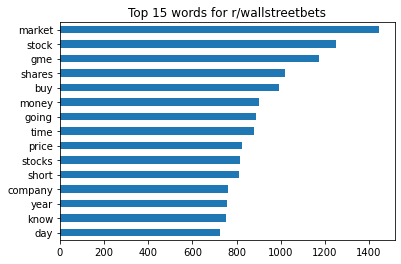

In [121]:
# top 15 most used words for r/wsb
wsb_cvec.sum().sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Top 15 words for r/wallstreetbets')

Text(0.5, 1.0, 'Top 15 words for r/PovertyFinance')

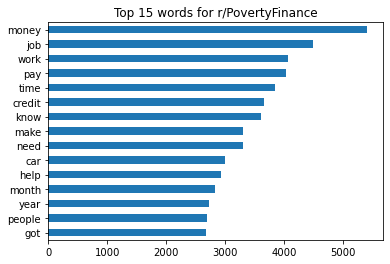

In [122]:
# top 15 most used words for r/povertyfinance
pfin_cvec.sum().sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Top 15 words for r/PovertyFinance')

In [123]:
#preparing 2 separate dicts for word cloud

wsb_dict = dict(zip(wsb_cvec.sum().index,wsb_cvec.sum()))

pfin_dict = dict(zip(pfin_cvec.sum().index,pfin_cvec.sum()))

Text(0.5, 1.0, 'Frequently occuring words for r/wallstreetbets')

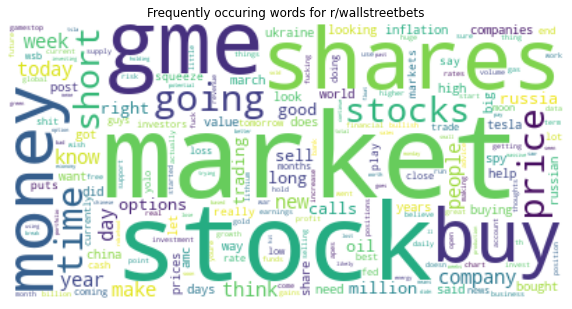

In [124]:
#wordcloud for wsb

plt.figure(figsize=(10,6))
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(wsb_dict)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.title('Frequently occuring words for r/wallstreetbets')

Text(0.5, 1.0, 'Frequently occuring words for r/PovertyFinance')

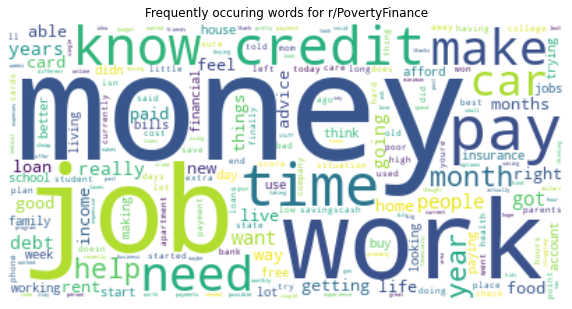

In [125]:
#wordcloud for povertyfinance

plt.figure(figsize=(10,6))
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(pfin_dict)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.title('Frequently occuring words for r/PovertyFinance')

### Analysis

We can see that some of the top most used words in r/wsb are 'market', 'stock', 'gme', 'shares', 'price'. These are all indicators to show that people posting in r/wsb are more aggresive in growing their capital through investing in the stock market. 'gme' is the stock of 'GameStop Corp.', whose price saw a significant increase due to redditors in wsb rallying together to buy the stock <sup> 3 </sup>. Hence, we see that not only are wsb redditors interested in the stock market, they have huge interest in 'meme stocks', which are stocks that gained popularity among retail investors through social media. These stocks are highly volatile and are for investors with a higher risk appetite.

On the other hand, the top words in r/povertyfinance include 'job', 'work' and 'pay'. This can be interpreted as people posting in r/povertyfinance are more focused on earning money through their job. They are also more worried about their finances as we see words such as 'credit' included in the top 15.

It also seems like the people posting in r/povertyfinance are more in desperate need of help, as we can see the words 'help' and 'need' appear.

For both subreddits, we see that words describing time often come up, such as 'year', 'month'/'day' and 'time'. This is understandable as money is always compared to time, such as monthly/yearly pay or company performance.

Next, let us now explore on how the community interacts with the posts to see if we can uncover more findings and links to the top words. The variables we will be looking at are upvote ratio and number of comments.

Upvotes determine whether the community has found the words used in their respective subreddits to be reliable and in-line with the purpose of the subreddit. Upvotes ratio is the percentage of upvotes compared to total up/down votes. Number of comments represent can tell us what are the words that spark hot topics for discussion.

In [126]:
# filter out the vector count of top 15 words
wsb_top15 = wsb_cvec.sum().sort_values(ascending=False).index[:15]

wsb_top15_df = wsb_cvec[wsb_top15]

# append upvote ratios and comments to top 15 words dataframe
wsb_top15_df['upvotes_ratio'] = wsb_df2['upvote_ratio'].values
wsb_top15_df['comments']= wsb_df2['num_comments'].values

In [127]:
# filter out the vector count of top 15 words
pfin_top15 = pfin_cvec.sum().sort_values(ascending=False).index[:15]

pfin_top15_df = pfin_cvec[pfin_top15]

# append upvote ratios and comments to top 15 words dataframe
pfin_top15_df['upvotes_ratio'] = pfin_df2['upvote_ratio'].values
pfin_top15_df['comments']= pfin_df2['num_comments'].values

In [128]:
#value counts of total upvotes ratio
display(wsb_top15_df['upvotes_ratio'].value_counts())
display(pfin_top15_df['upvotes_ratio'].value_counts())

1.000    9582
0.990       7
0.500       7
0.400       2
0.940       1
Name: upvotes_ratio, dtype: int64

1.000    9449
0.990     102
0.500      51
0.670      25
0.970      13
0.600      12
0.250      11
0.330      11
0.750      10
0.890       8
0.800       8
0.960       7
0.200       7
0.710       7
0.630       7
0.980       7
0.830       6
0.170       6
0.560       6
0.810       5
0.870       5
0.770       5
0.920       5
0.540       5
0.290       5
0.950       5
0.380       4
0.860       4
0.730       4
0.400       4
0.910       4
0.840       4
0.570       4
0.740       3
0.900       3
0.640       3
0.820       3
0.940       3
0.720       3
0.220       3
0.130       3
0.440       2
0.180       2
0.230       2
0.700       2
0.850       2
0.430       2
0.880       2
0.410       2
0.760       2
0.270       2
0.360       2
0.580       2
0.620       2
0.780       2
0.650       1
0.100       1
0.680       1
0.660       1
0.210       1
0.460       1
0.930       1
0.140       1
0.470       1
0.550       1
0.160       1
0.610       1
0.790       1
Name: upvotes_ratio, dtype: int64

### Analysis

We see that we can't really tell much from the upvotes ratio as it is highly skewed to the mode of 1. This is reflective of people's behavior, where people tend to upvote posts they resonate with, and ignore instead of downvoting posts that they dislike. This is especially so for wsb. Let us focus more on r/povertyfinance.

In [129]:
# getting the mean upvotes ratio for each top 15 word
pfin_upvotes_df = pd.DataFrame()
    
for col in pfin_top15_df.columns[:-2]:
    pfin_upvotes_df[col] = [pfin_top15_df[pfin_top15_df[col]>0]['upvotes_ratio'].mean()]
    
pfin_upvotes_df = pfin_upvotes_df.T

In [130]:
# renaming columns and sorting
pfin_upvotes_df.rename(columns = {0:'ratio'},inplace=True)
pfin_upvotes_df.sort_values(by='ratio',ascending=False,inplace=True)
pfin_upvotes_df

ratio
job     0.992
time    0.992
got     0.991
credit  0.991
pay     0.991
car     0.990
month   0.990
work    0.990
make    0.990
year    0.990
know    0.989
people  0.989
money   0.988
need    0.988
help    0.988

### Analysis

We see here that it is not very useful as the numbers are highly skewed towards 1. Let us perhaps study ratios of less than 30%

Text(0.5, 1.0, 'r/povertyfinance upvotes ratio <30% count')

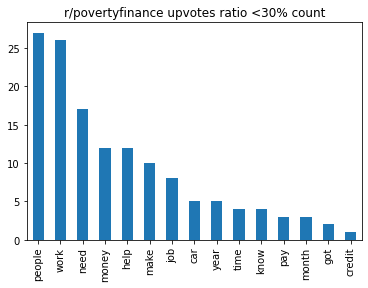

In [131]:
# filtering out low voted posts

less_than_30_ratio = pfin_top15_df[pfin_top15_df['upvotes_ratio']<0.3].iloc[:,:-2]
less_than_30_ratio.sum().sort_values(ascending=False).plot.bar()
plt.title('r/povertyfinance upvotes ratio <30% count')

### Analysis

We see that posts containing 'people' or 'work' are the ones that have lowest upvote ratio. Let us deep dive into these posts to find out what resonates with the community.

In [132]:
ppl_low_vote_df = pfin_df[pfin_df['new_text'].str.contains('people') & (pfin_df['upvote_ratio']<0.3)]

for text in ppl_low_vote_df['new_text']:
    display(text)

' I made outreach calls for work. Been looking for over a year. No one is hiring. "Your resume will be kept in our data base" is what I am told.\n\nMy resumes are tailored, and get lost in applicant tracking systems. But that\'s what we\'re required to use.\n\nI need north of $25/hour because of healthcare costs, and my experience and education would support that. \n\nI need 8am-6pm work hours.\n\nI need a gas card. I\'m not asking anyone on Reddit for a handout.\n\nUnited Way has NO resources and told me to call up churches if I need a gas card. Gas doesnt last forever. I need work.\n\nChurches will not help me. They will not offer me a crumb. I\'ve sent my resume around and the churches tell me, "just" move to a Blue State. \n\nDisregard car drivers license, car tags, registration, insurance, gas to travel and my not having a PLAN and a job to go to.\n\nI\'ve already moved 3 States and this one here is where I have to die then. Moving doesnt solve all problems unless I have a job to 

"I'd need your email to send the invite to you. Believe it's a $40 box for free with you likely paying shipping (for about $9). Will require credit/debit info but if you cancel before the selection deadline for the following week, you won't be charged. Free EveryPlate box each for 4 people"

' Short answer: Because there are hyperproductive people and there is only so much work to be done.\n\nLong answer: Let us argue that every working person has to provide enough real, tangible, concrete value (food, housing, electricity etc.) for two people (retirees, kids, pregnant women, disabled, diseased, administrators, politicians, police, military, salesmen, artists etc.). Let us estimate the amount of money he has to earn per month at 2000 $ (1000$ housing, 600$ food, 400$ other expenses like clothes, water, electricity).\n\n\\[ Side note: Students can live on 1000$ or less a month, my father, uncle, brother and me all managed fine. Also, I´m not saying that police and military are useless, just that they don´t actively increase the amount of real, tangible, concrete value being produced. Much more, they prevent the value from decreasing through criminality and chaos. \\]\n\nNow let´s look at a different example: A capitalist has an apartment block of 100 apartments planned and 

' Can you guys please join Acorns using my referral link? If I get 4 people to sign up, I get a $1000 bonus that would really set me ahead financially. Thank you guys in advance'

### Analysis

We see that the posts that are negatively viewed by the poverty finance community are ad-like posts that try to get people to join their referral links. Moreover, the 1st post is highly demanding, claiming that he/she needs a certain salary/benefits and this may have irked the community. The last post explains to the public why people have low wages (e.g. automation) and this have also caused outrage as people do not like to be told that they have low wages because they do not upskill.

In [133]:
ppl_low_vote_df = pfin_df[pfin_df['new_text'].str.contains('work') & (pfin_df['upvote_ratio']<0.3)]

for text in ppl_low_vote_df['new_text']:
    display(text)

' I made outreach calls for work. Been looking for over a year. No one is hiring. "Your resume will be kept in our data base" is what I am told.\n\nMy resumes are tailored, and get lost in applicant tracking systems. But that\'s what we\'re required to use.\n\nI need north of $25/hour because of healthcare costs, and my experience and education would support that. \n\nI need 8am-6pm work hours.\n\nI need a gas card. I\'m not asking anyone on Reddit for a handout.\n\nUnited Way has NO resources and told me to call up churches if I need a gas card. Gas doesnt last forever. I need work.\n\nChurches will not help me. They will not offer me a crumb. I\'ve sent my resume around and the churches tell me, "just" move to a Blue State. \n\nDisregard car drivers license, car tags, registration, insurance, gas to travel and my not having a PLAN and a job to go to.\n\nI\'ve already moved 3 States and this one here is where I have to die then. Moving doesnt solve all problems unless I have a job to 

"I want to apologize and thank everyone here for sincerely trying to help me with suggestions.💕\n\nAll of you are hardworking, kind and special. \n\nI am not asking for any handouts here or in any other forum. \n\nI'm crying as I type this because I know the odds are against me for trying to get work to get back on my feet. \n\nI didn't work this hard in my life to end up here. I believe that we all have a desire to thrive and not just survive. \n\nSome of us lost our job references from years back. I reported fraud in the finance world, and I havent been able to recover professionally. I cant get FT professional work inside an office environment. Its going on 4 years.\n\nMy health issues have caught up to me. I'm not disabled. I cant work without access to healthcare.\n\nI moved to a different State to start my life over, then Covid hit. I lost my job last year within 3 months.\n\nThe location where I am now, is generational families. Its filled with nepotism and cronyism. I don't hav

"I'm 23 still living with my parents and I have got nothing financially and I need money to pay for my parents debt. Anyone have tips to get my life back on track? I tried being a professional in some fps shooter and skipped college but that didn't work out it was just a waste of time. What to do when you are completely broke"

' Short answer: Because there are hyperproductive people and there is only so much work to be done.\n\nLong answer: Let us argue that every working person has to provide enough real, tangible, concrete value (food, housing, electricity etc.) for two people (retirees, kids, pregnant women, disabled, diseased, administrators, politicians, police, military, salesmen, artists etc.). Let us estimate the amount of money he has to earn per month at 2000 $ (1000$ housing, 600$ food, 400$ other expenses like clothes, water, electricity).\n\n\\[ Side note: Students can live on 1000$ or less a month, my father, uncle, brother and me all managed fine. Also, I´m not saying that police and military are useless, just that they don´t actively increase the amount of real, tangible, concrete value being produced. Much more, they prevent the value from decreasing through criminality and chaos. \\]\n\nNow let´s look at a different example: A capitalist has an apartment block of 100 apartments planned and 

" [F] Happy humpday! Someone entertain me while my husband's at work 🍑"

### Analysis

Once again we see that the posts that are negatively viewed by the poverty finance community are ad-like/troll posts. Posts that are highly demanding also do not bode well with the community.

Hence, we see that though this is a group that reaches out for advice and help, one should not be too demanding or the post will be condemned by the community.

We however do not see much downvoted posts in r/wsb. 

This thus reflects the tone of posts for individuals who require safer investment plans, where they tend to complain more about their financial situation.

Let us now explore the number of comments to try and gauge if we can seperate the 2 types of individuals by popularity.

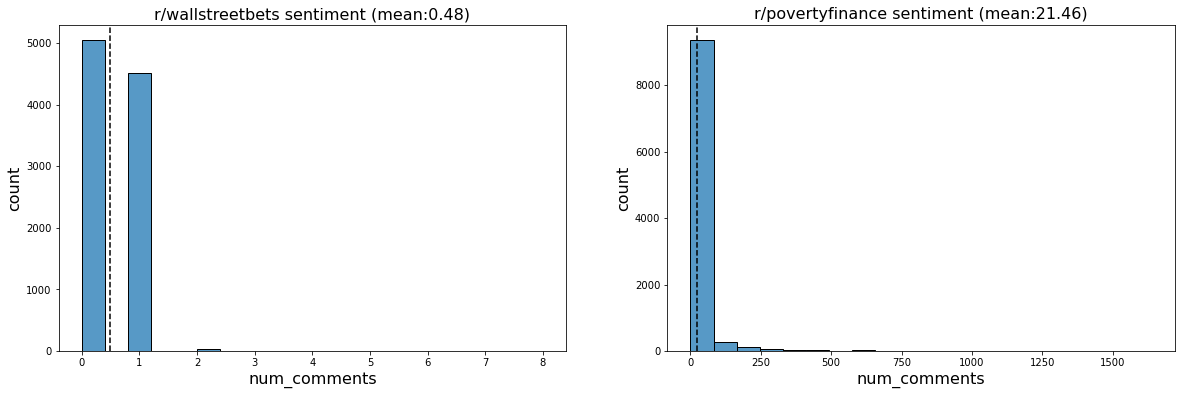

In [134]:
# Plotting general overview of number of comments

def sub_plot_function(column,bins):
    fig,ax = plt.subplots(1,2, figsize = (20,6))

    ax = ax.ravel()

    sns.histplot(combined_df[combined_df['from_wsb'] == 1][column].values, bins = bins, ax = ax[0])
    sns.histplot(combined_df[combined_df['from_wsb'] == 0][column].values, bins = bins, ax = ax[1])
    wsb_mean = combined_df[combined_df['from_wsb']==1][column].mean()
    pfin_mean = combined_df[combined_df['from_wsb']==0][column].mean()

    ax[0].axvline(wsb_mean, ls='--', color='black')
    ax[1].axvline(pfin_mean, ls='--', color='black')

    ax[0].set_xlabel(column,fontsize=16)
    ax[1].set_xlabel(column,fontsize=16)
    ax[0].set_ylabel('count',fontsize=16)
    ax[1].set_ylabel('count',fontsize=16)
    ax[0].set_title(f'r/wallstreetbets sentiment (mean:{round(wsb_mean,2)})',fontsize=16)
    ax[1].set_title(f'r/povertyfinance sentiment (mean:{round(pfin_mean,2)})',fontsize=16)
    
sub_plot_function('num_comments',20)

### Analysis

We can see that for both subreddits, the number of comments is skewed to the right. However, we note that r/povertyfinance has a much higher mean (21.46) than r/wsb (0.48). This is because r/povertyfinance has much more posts that have a large number of comments. When we investigated further, we understand that posts in r/povertyfinance tend to attract more comments as they are more desperate and tend to ask the community for help/advice. This this attracted a higher number of comments. This provides insights that may help to differentiate between people who require basic savings plans and those that are looking for high growth investment plans.

In [135]:
pfin_comments_df = pd.DataFrame()
wsb_comments_df = pd.DataFrame()

# filtering out the word count vectors for top 15 words and calculating the mean comments for each word

for col in wsb_top15_df.columns[:-2]:
    wsb_comments_df[col] = [wsb_top15_df[wsb_top15_df[col]>0]['comments'].mean()]
    
for col in pfin_top15_df.columns[:-2]:
    pfin_comments_df[col] = [pfin_top15_df[pfin_top15_df[col]>0]['comments'].mean()]
    
pfin_comments_df = pfin_comments_df.T
wsb_comments_df = wsb_comments_df.T

In [136]:
# renaming and sorting for plotting
pfin_comments_df.rename(columns = {0:'comments'},inplace=True)
pfin_comments_df.sort_values(by='comments',ascending=False,inplace=True)

wsb_comments_df.rename(columns = {0:'comments'},inplace=True)
wsb_comments_df.sort_values(by='comments',ascending=False,inplace=True)

Text(0, 0.5, 'Mean Count')

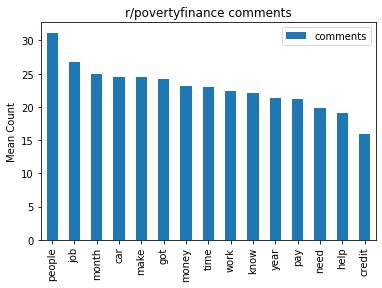

In [137]:
pfin_comments_df.plot.bar()
plt.title('r/povertyfinance comments')
plt.ylabel('Mean Count')

Text(0, 0.5, 'Mean Count')

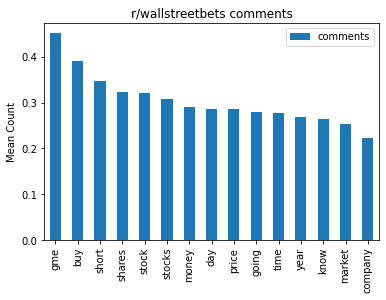

In [138]:
wsb_comments_df.plot.bar()
plt.title('r/wallstreetbets comments')
plt.ylabel('Mean Count')

### Analysis

We can see that for r/povertyfinance, the words that elicit the most comments are those that include the words 'people' and 'job'. The posts containing people are usually about comparing their financial situation with others. This tends to elicit alot of comments of people sharing their experiences, or disagreeing with them. The word job also generates comments as these posts are usually seeking on help regarding job search and people tend to comment on their recommendations or criticize if they have unrealistic expectations.

This is in contrast with r/wsb, where the posts with top comments have words like 'gme' and 'buy'/'short'. Through inspecting the posts, we realize that these posts are usually posts where they discuss on the market situation and what price to enter/exit. Hence, this further strengthens the point that posts in r/wsb are from people who are looking to increase their capital through investing.

Regarding time concerning words, r/povertyfinance have lots of comments for 'month', and this usually refers to things like how they can get through the month's bills. For r/wsb, the word 'day' elicits alot of comments as these posts usually are about day trading or what day to enter the market.

We can thus explore using comments to differentiate between the 2 groups of individuals, especially since people in dire financial situation tend to seek more help in their posts.

Next, we will move on to analyze bigram words.

In [139]:
# Tokenizing/counting the words again, but changing number of words to bigram
cvec = CountVectorizer(stop_words=new_stop_words,
                      tokenizer = StringTokenizer(),
                      max_features = 1000,
                      strip_accents = 'unicode',
                      ngram_range = (2,2))

In [140]:
#putting the counts in dataframe
wsb_bi_cvec = pd.DataFrame(cvec.fit_transform(wsb_df2['new_text']).todense(),columns = cvec.get_feature_names())
pfin_bi_cvec = pd.DataFrame(cvec.fit_transform(pfin_df2['new_text']).todense(),columns = cvec.get_feature_names())

Text(0.5, 1.0, 'Top 15 bigram words for r/wallstreetbets')

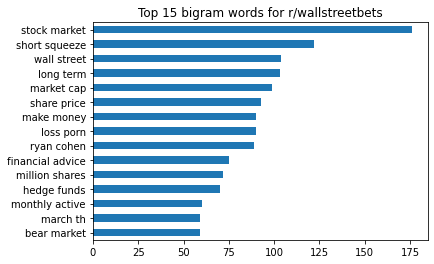

In [141]:
# top 15 most used bigram words for r/stocks
wsb_bi_cvec.sum().sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Top 15 bigram words for r/wallstreetbets')

Text(0.5, 1.0, 'Top 15 bigram words for r/povertyfinance')

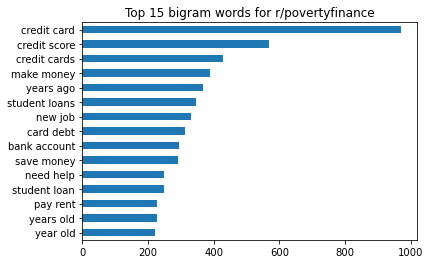

In [142]:
# top 20 most used bigram words for r/povertyfinance
pfin_bi_cvec.sum().sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Top 15 bigram words for r/povertyfinance')

In [143]:
# Filtering out the top common words in the opposite subreddit to discover similarities

wsb_bi_index = wsb_bi_cvec.sum().sort_values(ascending=False).head(15).index

pfin_bi_index = pfin_bi_cvec.sum().sort_values(ascending=False).head(15).index

wsb_index_col = [col for col in wsb_bi_index if col in pfin_bi_cvec.columns]
pfin_index_col = [col for col in pfin_bi_index if col in wsb_bi_cvec.columns]

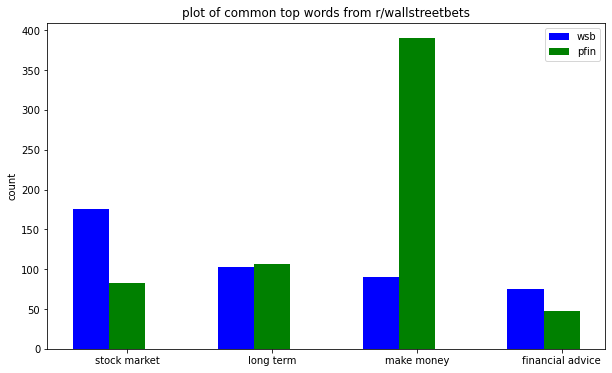

In [144]:
# plot of common words in r/wsb that also appears in r/povertyfinance

plt.figure(figsize=(10,6))

n = np.arange(len(wsb_index_col))
r=0.25

plt.bar(n,wsb_bi_cvec[wsb_index_col].sum().values, 
        color = 'b',label = 'wsb',width = 0.25)

plt.bar(n+r,pfin_bi_cvec[wsb_index_col].sum().values,
       color = 'g',label = 'pfin',width = 0.25)

plt.xticks(n+r,wsb_index_col)
plt.title('plot of common top words from r/wallstreetbets')
plt.ylabel('count')

plt.legend()

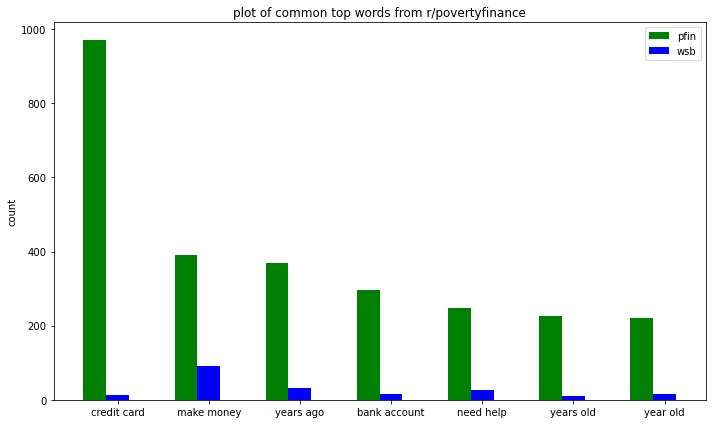

In [145]:
# plot of common words in r/poverty finance that also appears in r/wsb

plt.figure(figsize=(10,6))

n = np.arange(len(pfin_index_col))
r=0.25

plt.bar(n,pfin_bi_cvec[pfin_index_col].sum().values,
       color = 'g',label = 'pfin',width = 0.25)

plt.bar(n+r,wsb_bi_cvec[pfin_index_col].sum().values, 
        color = 'b',label = 'wsb',width = 0.25)

plt.xticks(n+r,pfin_index_col)
plt.title('plot of common top words from r/povertyfinance')
plt.ylabel('count')

plt.legend()

plt.tight_layout()

### Analysis

We can see that the top words from r/povertyfinance that are also in r/wsb are usually time based such as 'long term' and 'years ago'. The 'long term' in r/wsb tend to indicate at investing in the long term, while the long term in r/povertyfinance points to how to ensure stable finances in the 'long term'. For 'years ago', r/wsb tend to refer to analysis of the stock market, while r/povertyfinance is usually people sharing their financial transformation from years ago.

We see that more of the top terms from r/povertyfinance do exist in r/wsb rather than the other way round, albeit at low figures for each category. We see that 'credit card' repayment is a main concern for r/povertyfinance, but not for r/wsb. We can also see that r/povertyfinance is more explicit in seeking help, whereas r/wsb users seek advice on investment. Hence, we can see that though both are subreddits about finance, r/povertyfinance differes from r/wsb where they use more basic financial terms. With this, we have a better idea of how our machine learning models can help to differentiate posts between the 2 subreddits through categorising words. Let us next move on to doing sentiment analysis of the 2 subreddits.

In [146]:
#instantiating vader object
vad = SentimentIntensityAnalyzer()

# extracting the sen scores for each post
combined_df['sen_scores'] = combined_df['new_text'].apply(lambda para: vad.polarity_scores(para)['compound'])

## Analysis

The Vader module refers to a dictionary of sentiments to give each post a Positivity and Negativity score that can be standardized in a range of -1 to 1.

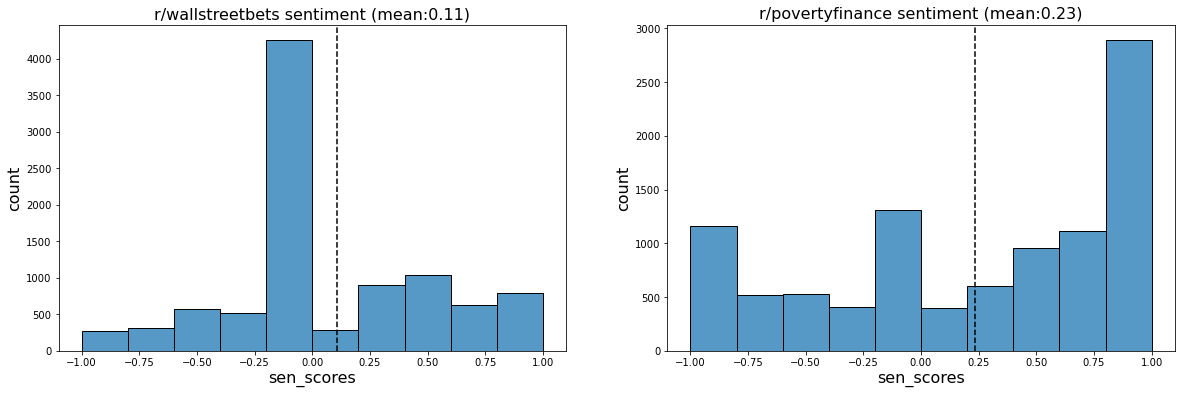

In [147]:
#plotting distribution of sentiment analysis

sub_plot_function('sen_scores',10)

### Analysis

We can see that a large bulk of the sentiment in r/wsb tend to be neutral. This is because there are more analytical posts rather than emotional posts. Moreover, the terms bull and bear market are usually used to describe good and bad for stocks. However, vader ranks such terms as neutral. 

For r/povertyfinance, we can see a more binary distribution, where there are more posts that have very negative sentiment or very positive sentiment. This is because people who posts in such forums regularly complain or share their achievements (e.g. becoming financially stable), thus resulting in a more binary distribution. Now that we have completed our data cleaning and EDA, we will begin to build our mode.

## Model Selection and Tuning

### Baseline Model

Our baseline model is when we simply randomly pick a subreddit for each post, which will be right 50% of the time. Our goal is to build a model that can predict better than our baseline model.

In [65]:
random.seed(1)

x = combined_df['new_text']
y = combined_df['from_wsb']

y.value_counts(normalize=True)

0   0.507
1   0.493
Name: from_wsb, dtype: float64

In [66]:
x_train, x_test, y_train, y_test= train_test_split(x,y)

In [67]:
# This will be our initial stop words
stop_words_base = ['wallstreet','bets','poverty','finance','wallstreetbets','wsb']

In [68]:
#Instantiating vectorizers

vectorizers = {'cvec':  CountVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_base),
              'tvec':TfidfVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_base)}

### Analysis

Count Vectorizers count the number of words in each post and outputs columns of count for each word. TFIDF is short for term frequency, inverse document frequency. What it does is that besides the word counts in each document, TFIDF also includes the occurrence of this word in other documents. Hence, it will put a smaller weightage on words that appear in many posts, and a higher weightage on the rarer words.

In [69]:
# Instantiating models

models = {'lr': LogisticRegression(),
         'rf': RandomForestClassifier(),
         'nb': MultinomialNB()}

In [70]:
# function to run vectorizer,model and generate metrics

def run_model(vec,mod):
    
    results = {}
    
    pipe = Pipeline(
        [
        (vec, vectorizers[vec]),
        (mod, models[mod])
        
    ]
    )
    
    pipe.fit(x_train,y_train)
    
    results['model'] = mod + ' ' + vec
    results['train'] = pipe.score(x_train,y_train)
    results['test'] = pipe.score(x_test,y_test)
    
    predictions = pipe.predict(x_test)
    
    results['roc_auc_score'] = roc_auc_score(y_test,predictions)
    results['precision'] = precision_score(y_test,predictions)
    results['recall'] = recall_score(y_test,predictions)
    results['f_score'] = f1_score(y_test,predictions)

    print ('## METRICS ##')
    
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
    
    print(f'True Negatives: {tn}')
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    
    return pipe

### Analysis

First, let us contextualize some of the metrics.

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems.  AUC stands for Area under the ROC Curve. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between high growth investors and financially challeneged investors.

Precision is defined as the number of true positives divided by the amount of true positives plus the amount of false positives. It is the ability of a classification model to identify only the relevant data points. For our case, it is the percentage of all the individuals that the model predicts as high growth investors from r/wsb, over the percentage of customers that actually are high growth investors.

Recall is defined as the number of true positives divided by the amount of true positives plus the amount of false negatives. It is the percentage of investors the model successfully identifies as high growth investors.

The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model’s precision and recall.

Now that we have defined the metrics and contextualised to our use case, we will move on to building our first model using Multinomial Naive Bayes.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{message is wsb}|\text{words in message}) &=& \frac{P(\text{words in message}|\text{message is wsb})P(\text{message is wsb})}{P(\text{words in message})}
\end{eqnarray*}
$$

Naive Bayes calculates the conditional probability that a post is in r/wsb or r/povertyfinance given the words that are in the message.

However, it makes the assumption that features/words are independent of one another. This is hard to achieve, as we would expect certain words like market to follow after the word stock.


In [71]:
tvec_nb = run_model('tvec', 'nb')

## METRICS ##


{'model': 'nb tvec',
 'train': 0.9095824777549624,
 'test': 0.8780287474332649,
 'roc_auc_score': 0.8757941472455526,
 'precision': 0.9535951045385007,
 'recall': 0.78803202697008,
 'f_score': 0.8629441624365481}

True Negatives: 2406
True Positives: 1870
False Positives: 91
False Negatives: 503


In [72]:
cvec_nb = run_model('cvec', 'nb')

## METRICS ##


{'model': 'nb cvec',
 'train': 0.915400410677618,
 'test': 0.9028747433264888,
 'roc_auc_score': 0.9022937934286419,
 'precision': 0.9177660510114336,
 'recall': 0.8794774546986937,
 'f_score': 0.8982139014417904}

True Negatives: 2310
True Positives: 2087
False Positives: 187
False Negatives: 286


### Analysis

Our initial model running on TFIDF vectorizer and Naive Bayes are able to classify 87.8% of posts accurately. For count vectorizer and Naive Bayes, we see that it is able to improve to 90.2%.

Next, we will move to try and use a Logistic Regression model.

Logistic regression is a classification model that gives us the probabilities of being in each subreddit. We can use these probabilities to choose which class we predict the post to be from and the interpretation of coefficients is in terms of the log-odds. The odds in our case is the likelihood of being in one subreddit (e.g. r/wsb) as compared to it be in the other subreddit (e.g. r/povertyfinance).

The mathematical equation is as follow:

$$\log\bigg(\frac{P(y=1)}{1-P(y=1)}\bigg) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \cdots + \beta_px_p$$

To interpret the coefficients, we exponentiate it and evaluate the figure as the increase/decrease in likelihood with 1 unit increase of that feature.

In [73]:
cvec_lr = run_model('cvec', 'lr')

## METRICS ##


{'model': 'lr cvec',
 'train': 0.9711156741957563,
 'test': 0.9131416837782341,
 'roc_auc_score': 0.9141055233410308,
 'precision': 0.8796728971962616,
 'recall': 0.9519595448798989,
 'f_score': 0.9143897996357012}

True Negatives: 2188
True Positives: 2259
False Positives: 309
False Negatives: 114


In [74]:
tvec_lr = run_model('tvec', 'lr')

## METRICS ##


{'model': 'lr tvec',
 'train': 0.9413415468856947,
 'test': 0.9092402464065709,
 'roc_auc_score': 0.9101649328541067,
 'precision': 0.8770011714174151,
 'recall': 0.9464812473662031,
 'f_score': 0.9104175111471423}

True Negatives: 2182
True Positives: 2246
False Positives: 315
False Negatives: 127


### Analysis

We can see that our Logistic Regression model does better than our Naive Bayes model. Let us now move on and try using Random Forest Classification.

The general steps on how Random Forest is run is as follows: 

1. First, we generate a bootstrap sample
2. Then, we generate a random subset of all the eligible features
3. We then proceed to build a tree using only those eligible features

Through using different eligible features for each tree, we are able to de-correlate our trees as compared to building trees only on multiple bootstrap samples from the initial sample. Random Forest does majority voting among all its trees to predict which subreddit the post belongs to.

In [214]:
tvec_rf = run_model('cvec', 'rf')

## METRICS ##


{'model': 'rf cvec',
 'train': 0.9983572895277207,
 'test': 0.862217659137577,
 'roc_auc_score': 0.8624369470925162,
 'precision': 0.8499177631578947,
 'recall': 0.8710493046776233,
 'f_score': 0.860353798126951}

True Negatives: 2132
True Positives: 2067
False Positives: 365
False Negatives: 306


In [215]:
cvec_rf = run_model('tvec', 'rf')

## METRICS ##


{'model': 'rf tvec',
 'train': 0.9983572895277207,
 'test': 0.8603696098562629,
 'roc_auc_score': 0.8608231268166554,
 'precision': 0.8417440452159871,
 'recall': 0.8786346396965866,
 'f_score': 0.8597938144329897}

True Negatives: 2105
True Positives: 2085
False Positives: 392
False Negatives: 288


### Analysis

We see that random forest does not perform as well as our Logistic Regression Model. However, we can still use the random forest model to study the words that are most effective in separating out posts from the 2 subreddits through the gini impurity. The gini impurity is a measurement of the likelihood of an incorrect classification of each word. Hence, the words that lead to a greatest decrease in gini impurity play a more crucial role in classifying our 2 subreddits. We will use the tfidif vectorizer because the tfidf vectorizing gives less weight to more common words. Hence, words that are not too common but are effective in splitting the 2 subreddits will be featured as important by our random forest model.

In [71]:
# Instantiating rf model with tfidf

forest = RandomForestClassifier()

tvec = TfidfVectorizer(tokenizer=StringTokenizer(), stop_words = new_stop_words)

tvec_rf = pd.DataFrame(tvec.fit_transform(x_train).todense(),columns = tvec.get_feature_names())

forest.fit(tvec_rf,y_train)

RandomForestClassifier()

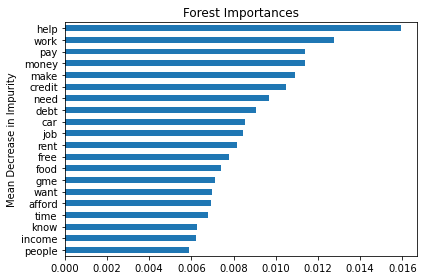

In [72]:
# filtering out top 20 important words and plotting

importances = forest.feature_importances_

forest_importances = pd.Series(importances, index= tvec.get_feature_names())

forest_importances_20 = forest_importances.sort_values(ascending=True).tail(20)

fig, ax = plt.subplots()
forest_importances_20.plot.barh(ax=ax)

ax.set_title("Forest Importances")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

### Analysis

As expected from our eda, the cry for help is a strong separator of the 2 types of individuals. Moreover, the words 'credit' and 'income' are also more basic financial terms representing the needs of indivuals who require more basic financial plans rather than risky high growth plans.

We see that random forest does not perform better than our logistic regression model. However we want to continue improving our models. Let us try adding on english stop words to our model. Moreover, from our EDA, we had identified certain words that are constantly seen across both subreddits. Let us stop out these words to see if our model can differentiate posts between these 2 subreddits better.

In [73]:
#Instantiating vectorizers with new stop words

eda_stop_words = [word for word in pfin_top15 if word in wsb_top15]

eda_bi_stop_words = [word for word in pfin_bi_index if word in wsb_bi_index]

display(eda_stop_words)
display(eda_bi_stop_words)

new_stop_words2 = new_stop_words + eda_stop_words+eda_bi_stop_words

vectorizers = {'cvec':  CountVectorizer(tokenizer=StringTokenizer(), stop_words = new_stop_words2),
              'tvec':TfidfVectorizer(tokenizer=StringTokenizer(), stop_words = new_stop_words2)} #new_stop_words

['money', 'time', 'know', 'year']

['make money']

In [74]:
tvec_lr = run_model('tvec', 'lr')

## METRICS ##


{'model': 'lr tvec',
 'train': 0.9441478439425052,
 'test': 0.9121149897330596,
 'roc_auc_score': 0.9128531988069628,
 'precision': 0.8851485148514852,
 'recall': 0.9418457648546145,
 'f_score': 0.9126173948550429}

True Negatives: 2207
True Positives: 2235
False Positives: 290
False Negatives: 138


In [75]:
cvec_lr = run_model('cvec', 'lr')

## METRICS ##


{'model': 'lr cvec',
 'train': 0.9654346338124572,
 'test': 0.9082135523613963,
 'roc_auc_score': 0.9092997564207264,
 'precision': 0.8715277777777778,
 'recall': 0.9519595448798989,
 'f_score': 0.9099697885196375}

True Negatives: 2164
True Positives: 2259
False Positives: 333
False Negatives: 114


### Analysis

We see that our models does not beat the initial Count Vectorizer Logistic Regression model of 91.3%. Let us do some initial tuning to our initial model.

In [124]:
cvec_params = {
    # Setting a limit of n-number of features included/vocab size
    'cvec__max_features': [1000,2000],
    
    # Testing with bigrams
    'cvec__ngram_range':[(1,1), (1,2), (2,2)]

}

tvec_params = {
    'tvec__max_features': [1000,2000],

    'tvec__ngram_range':[(1,1), (1,2), (2,2)]
}

lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1','elasticnet'],

    # Trying different alphas of: 10, 1, 0.1 (C = 1/alpha)
    'lr__C':[0.1,1,10]
    
}

In [111]:
#grid searching for ideal params
pipe = Pipeline(
        [
        ('cvec', vectorizers['cvec']),
        ('lr', models['lr'])
        
    ]
    )

gs = GridSearchCV(pipe, param_grid = {**cvec_params, **lr_params}, cv = 3)
        
gs.fit(x_train,y_train)
        
best_params = gs.best_params_

display(best_params)

{'cvec__max_features': 2000,
 'cvec__ngram_range': (1, 1),
 'lr__C': 1,
 'lr__penalty': 'l2'}

In [112]:
# updating our dictionaries with the best params
models['lr'] = LogisticRegression(C = 1, penalty = 'l2')
vectorizers['cvec'] = CountVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_base, 
                                      max_features = 2000, ngram_range = (1,1))

In [114]:
# Find out the features that contribute most to classification.

lr_df = pd.DataFrame()
lr_df['feature_names'] = gs.best_estimator_[0].get_feature_names()
lr_df['coef'] = gs.best_estimator_[1].coef_.T

# lr_df = pd.DataFrame(gs.best_estimator_[1].coef_.T,columns = ['coef'])
# lr_df['feature_names'] = gs.best_estimator_[0].get_feature_names()
lr_df['expo_coef'] = lr_df['coef'].apply(np.exp)
lr_df.sort_values(by='expo_coef',ascending=False).head(10)

feature_names  coef  expo_coef
722            gme 3.056     21.252
1988          yolo 2.598     13.441
1009          lose 2.399     11.015
90            apes 2.380     10.808
1463     robinhood 2.366     10.658
1478       russian 2.291      9.884
1114          moon 2.256      9.544
1441        retard 2.067      7.899
1394     recession 2.030      7.612
1442      retarded 2.021      7.543

In [115]:
lr_df.sort_values(by='expo_coef',ascending=True).head(10)

feature_names   coef  expo_coef
393         crypto -2.902      0.055
419           debt -2.210      0.110
389         credit -2.079      0.125
998           loan -1.914      0.148
1851  unemployment -1.856      0.156
290          cheap -1.835      0.160
661           food -1.807      0.164
1195        online -1.797      0.166
256            car -1.747      0.174
517      education -1.730      0.177

### Analysis

We can see that stock names and broker names play an important role in differentiating between the 2 kinds of investors, as it signals the want for a higher growth investment strategy rather than basic savings plans. They also tend to use words such as 'moon', which is a term known in investing as the increasing value of investments. Another term is 'apes', which is a term to derived from the movie 'The Planet of the Apes'. <sup> 1 </sup> It's a finance lingo that represents banding together to buy a stock. We should thus ensure that our model continuously updates itself with new terms in order to better identify the risk appetite of investors. This is also the case for other hot short term words, such as russia, where the conflict with Ukraine has introduced much volatility inthe markets <sup> 2 </sup>.

We can interprete the exponentiated coefficients, for example like 'moon', as being 9.5 times more likely to classify the subreddit as r/wsb and hence higher networth and growth seeking investor each time the word appears.

For terms that help in classifying into r/povertyfinance, we can see that the words debts/credit are strong signifiers of a person's financial situation. Basic needs such as 'food' is also a good indicator. Interestingly, the word that has a strong influence in classifying financially challenged individuals is crypto. Let us study such posts.

In [142]:
# sieving out crypto posts for investigation
for para in combined_df.loc[combined_df[combined_df['from_wsb']==0]['new_text'].str.contains('crypto').index]['new_text']:
    print (para)

thank you for reading did some posts lately but no one responds so if you comment at least  just to know my post is public will be grateful almost weeks ago cat had their kittens in my house and we couldn keep them but did at the end yesterday the mom was poisoned and bring her to urgrencies and ive spent money that could spend on medical care for my parents they didnt have medical check for years and they need or to buy the groceries of the month or pay march bills or to buy new stove fridge wash machine as they are damaged or to fix the car or my laptop as result in few hours  will have to leave the kittens abandoned in the streets ive could be able to help them if earn some money im student and think could do sime freelance job have extra time and skills in this way will be able to support my family too want to keep the kittens but cant
 have the option to come in an extra day every weekend to help since they are short handed jumped on it with the hustle mindset that could pack away

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



not sure if this is the right place for this tldr can study remotely on  yearly budget at yo only have my highschool degree combination of unfortunate circumstances and bad luck meant that until today ve mostly been working to provide for my family with no time energy or financial ability to get into collegeuniversity some weeks ago an estranged relative offered to put per year towards my education did the math and saw that can realistically add about year to that my dream has been to work with kidsteenagers as teacher therapist or social worker looking at sites like batchelorsportal see that most remote learning programmes can afford moving abroad are way over my budget does anyone have tipsadvice on where to look for more affordable remote learning options undergraduate on tight budget
removed having successful online business is not hard to create and will make world of difference
 you live abroad and one of the things that worries you most is economic problems such as how to make i

### Analysis

On inspection, the reason is because many of these posts are scams. We will add crypto to stop words.

**Next steps**: Apart from fine tuning our model through gridsearch, I feel that it would be interesting if we could try to tune our model with sentiment analysis scores. Our sentiment analysis scores are however numerical features. In order to build a model that can incorporate both bag of words and numerical features, we will need to extract the predicted probabilities from our bag of words model and input them into a second model together with the sentiment analysis scores.

In [143]:
#updating stop words to clear out spam scam posts

stop_words_base = stop_words_base + ['crypto']

models['lr'] = LogisticRegression(C = 1, penalty = 'l2')
vectorizers['cvec'] = CountVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_base, 
                                      max_features = 2000, ngram_range = (1,1))

In [144]:
#cvec lr proba

pipe = Pipeline(
        [
        ('cvec', vectorizers['cvec']),
        ('lr', models['lr'])
    ]
    )

pipe.fit(x_train,y_train)

x_train_df = pd.DataFrame(x_train)
x_test_df = pd.DataFrame(x_test)

# storing probabilitiy numeric figure for use later
x_train_df['proba'] = pipe.predict_proba(x_train)[:,1]
x_test_df['proba'] = pipe.predict_proba(x_test)[:,1]

lr = LogisticRegression()
rf = RandomForestClassifier()

In [145]:
# extracting sentiment scores for use
x_train_df['sen_scores'] = combined_df.loc[x_train_df.index]['sen_scores']
x_test_df['sen_scores'] = combined_df.loc[x_test_df.index]['sen_scores']

x_train_df2 = x_train_df[['proba','sen_scores']]
x_test_df2 = x_test_df[['proba','sen_scores']]

# training with sentiment scores and proba
rf.fit(x_train_df2,y_train)
lr.fit(x_train_df2,y_train)

LogisticRegression()

In [146]:
#displaying train and test scores for random forest
display(rf.score(x_train_df2,y_train))
display(rf.score(x_test_df2,y_test))

0.9952087611225188

0.8868583162217659

In [147]:
#displaying train and test scores for logreg

display(lr.score(x_train_df2,y_train))
display(lr.score(x_test_df2,y_test))

0.9449007529089665

0.9

### Analysis

We can see that when we take into account the sentiment score, the model does not improve at all. This is because Vader is a general dictionary which is not tuned towards financial terms and jargon <sup> 5 </sup>. Hence, it will not be able to predict finance terms like bull and bear well. Moreover, it is not able to read context well. For example, if the sentence is 'my pay was terrible for a few years. It then increased by five times', it may not be able to pick up that the sentiment was actually good as it couldn't take in the whole context but rather only a small number of words at a time. However, we note that in our EDA, the mean number of comments for r/povertyfinance is much more than r/wsb due to the nature of the posts where the poster is more desperate in seeking him. Hence, let us analyze if this feature can help our model predict better.

In [148]:
# extracting number of comments
x_train_df['num_comments'] = combined_df.loc[x_train_df.index]['num_comments']
x_test_df['num_comments'] = combined_df.loc[x_test_df.index]['num_comments']

x_train_df2 = x_train_df[['proba','num_comments']]
x_test_df2 = x_test_df[['proba','num_comments']]

#training proba amd comments
rf.fit(x_train_df2,y_train)
lr.fit(x_train_df2,y_train)

LogisticRegression()

In [149]:
display(rf.score(x_train_df2,y_train))
display(rf.score(x_test_df2,y_test))

0.9965776865160849

0.9209445585215605

In [150]:
display(lr.score(x_train_df2,y_train))
display(lr.score(x_test_df2,y_test))

0.9555783709787816

0.920123203285421

In [152]:
# extract the predict proba for further analysis
pred_proba = [i[1] for i in lr.predict_proba(x_test_df2)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [125]:
#fine tuning with gridsearch
pipe = Pipeline([('lr',LogisticRegression())])

gs = GridSearchCV(pipe, param_grid = lr_params, cv = 3)

gs.fit(x_train_df2,y_train)
        
best_params = gs.best_params_
best_score = gs.best_score_

display(best_params)
display(best_score)

{'lr__C': 0.1, 'lr__penalty': 'l2'}

0.9566735112936344

In [153]:
#Fitting in best params
lr = LogisticRegression(penalty = 'l2', C=0.1)
lr.fit(x_train_df2,y_train)
lr.score(x_test_df2,y_test)

0.9215605749486653

### Analysis

We can see that our Logistic Regression model improved to 92.1% after fine tuning our model. Next, let us move on to error analysis.

In [154]:
# confusion matrix of model, cvec_rf
predictions = lr.predict(x_test_df2)
cm = confusion_matrix(y_test, predictions)

In [155]:
cm_df = pd.DataFrame(data=cm, columns = ['predict pfin', 'predict wsb'], index=['actual pfin','actual wsb'])
cm_df

predict pfin  predict wsb
actual pfin          2260          237
actual wsb            145         2228

In [156]:
tn, fp, fn, tp = cm.ravel()
print('Accuracy: {}%'.format(round((tp+tn)*100/(tp+fp+tn+fn),2)))
print('Misclassification rate: {}%'.format(round((fp+fn)*100/(tp+fp+tn+fn),2)))
print('Precision: {}%'.format(round(tp*100/(tp+fp),2))) # when model predict yes, how many percent correct
print('True Positive Rate: {}%'.format(round(tp*100/(tp+fn),2))) # when actually yes, how many predict yes
print('True Negative Rate: {}%'.format(round(tn*100/(tn+fp),2))) # when actually no, how many predict no

Accuracy: 92.16%
Misclassification rate: 7.84%
Precision: 90.39%
True Positive Rate: 93.89%
True Negative Rate: 90.51%


### Analysis

True Negatives: Predicted r/povertyfinance and was indeed r/povertyfinance

True Positives: Predicted r/wsb and was indeed r/wsb

False Positives: Predicted r/wsb but was r/povertyfinance 

False Negatives: Predicted r/povertyfinance and was r/wsb

If the company was concerned about not having its customers take too much risk, it would want to reduce its false positive, as they would not want people who do not have extra capital to invest in risky investment plans. However, if the company is profit driven, it would want to minimize false negatives, as customers who invest in high growth stratgies are more profitable due to higher investment and fees, and they rather minimize the loss of such customers rather and accept more lower income individuals making risky investments than the other way round. Let us move on do error analysis on the misclassifications.

In [157]:
# extracting wrong classifications index
s1 = pd.Series(y_test)
s2 = pd.Series(predictions)

error_analysis_df = pd.DataFrame(s1.values,columns=['actual'],index = s1.index)
error_analysis_df['predictions'] = s2.values
error_analysis_df['pred_probs'] = pred_df['pred_probs']
false_neg_index = error_analysis_df[(error_analysis_df['actual']==1) & (error_analysis_df['predictions']==0)].index
false_pos_index = error_analysis_df[(error_analysis_df['actual']==0) & (error_analysis_df['predictions']==1)].index

In [158]:
#storing wrong classifications in a df

false_neg_df = combined_df.loc[false_neg_index]
false_pos_df = combined_df.loc[false_pos_index]

In [159]:
#reading texts on r/wsb predicted as r/povertyfinance
for para in false_neg_df['new_text']:
    print(para)

removed marriott bonvoy hilton honors and world of hyatt rewards programs
 just went through google and got this random suggestion on it
 sign up and receive in your cashapp now
 wtf is this how is anyone supposed to make money on days like these
 this show about the early days of cathie wood is quite cool good for her that she finally managed to get people to trust her with money
removed will credit card company increase credit limit in case of emergency ie to get out of country pay bill or get imprisoned etc 
 how to get  month from affiliate marketing and increase your income in less than months
removed if being gayputs is ruining your life make sure you have rope fund advice
 infeedo gets mn to assist organizations with measuring worker feelings as cross breed work plans get
 you people need this
  how to directly register retirement shares in your ira   hi wallstreetbets have been longtime lurking ape who writes shit comments and now am here to offer an educational methodology on 

In [160]:
#reading texts on r/povertyfinance predicted as r/wsb
for para in false_pos_df['new_text']:
    print(para)

 how new robin hood ceo buery plans to fight nyc poverty
 mods are gayer than me
removed check this out
 profit
 need money making coustom made bird oil paintings where toget started
 my titties look amazing in this picture don they 
 not sure if this goes here but feels right
 peekaboo 
 hello nice connecting with you want to know if you have heard about binary options trading
 if 𝘆𝗼𝘂𝘃𝗲 𝗴𝗼𝘁 𝗚𝗺𝗮𝗶𝗹 𝗶𝗻 days 𝘆𝗼𝘂 𝗰𝗮𝗻 𝗲𝗮𝗿𝗻 𝘂𝗽 𝗳𝗿𝗼𝗺 𝗜𝗻𝗯𝗼𝘅 𝗠𝗮𝗻𝗮𝗴𝗲𝗺𝗲𝗻𝘁 𝗱𝗶𝗿𝗲𝗰𝘁𝗹𝘆 𝗳𝗼𝗿 𝗺𝗼𝗿𝗲 𝗶𝗻𝗳𝗼𝗿𝗺𝗮𝘁𝗶𝗼𝗻 𝗼𝗿 𝗮𝘀𝗸 𝗛𝗼𝘄  
removed just young adult from the hood
 this is your invitation to fuck me raw 
very insightful post and comments on how growing up rich gives significant advantage 
 need gas for work cashapp in thoughtful image
 got all of this for before tax
hey guys has anyone done dpa grant in texas how long does it take thanks dpa grant in texas question
removed get referred to socialgood by using an invitation code gbjc and get withdrawable cashback for shopping upto in over stores worldwide
removed need funding fo

### Analysis

We see that misclassifications usually happen when they posted on words with high coefficients from the opposite subreddit such as 'stock' or 'credit card'. These cases are usually context based, where individuals who are financially challenged are posting in r/povertyfinance as they had lost money in 'stocks', which is a keyword in classifying r/wsb. There are also many posts which do not specifically mention finance that are also misclassified. Let us look at the top common words that have been misclassified for both subreddits.

In [163]:
# doing a word count on the wrong classifications

cvec = CountVectorizer(stop_words=new_stop_words,
                      tokenizer = StringTokenizer(),
                      max_features = 1000)
false_neg_cvec = pd.DataFrame(cvec.fit_transform(false_neg_df['new_text']).todense(),
                              columns = cvec.get_feature_names())
false_pos_cvec = pd.DataFrame(cvec.fit_transform(false_pos_df['new_text']).todense(),
                              columns = cvec.get_feature_names())

In [164]:
# wrong classifications for false negative
false_neg_words = false_neg_cvec.sum().sort_values(ascending=False).head(10).index
false_neg_words

Index(['llc', 'money', 'ira', 'make', 'account', 'help', 'shares', 'custodian',
       'know', 'people'],
      dtype='object')

In [165]:
# wrong classifications for false positive
false_pos_words = false_pos_cvec.sum().sort_values(ascending=False).head(10).index
false_pos_words

Index(['token', 'money', 'help', 'market', 'tmz', 'know', 'best', 'tokens',
       'new', 'financial'],
      dtype='object')

In [166]:
# checking for words that appear the most in both misclassifications and adding them to our stop words

error_stop_words = [word for word in false_neg_words if word in false_pos_words]
display(error_stop_words)

stop_words_3 = stop_words_base + error_stop_words
stop_words_3

['money', 'help', 'know']

['wallstreet',
 'bets',
 'poverty',
 'finance',
 'wallstreetbets',
 'wsb',
 'crypto',
 'money',
 'help',
 'know']

In [167]:
# re-running the model to check if accuracy improved
vectorizers = {'cvec':  CountVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_3),
              'tvec':TfidfVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_3)} #new_stop_words

In [169]:
run_model('cvec','lr')

## METRICS ##


{'model': 'lr cvec',
 'train': 0.9697467488021903,
 'test': 0.9127310061601642,
 'roc_auc_score': 0.9135376273694469,
 'precision': 0.8837667454688731,
 'recall': 0.9452170248630426,
 'f_score': 0.9134595805334963}

True Negatives: 2202
True Positives: 2243
False Positives: 295
False Negatives: 130


Pipeline(steps=[('cvec',
                 CountVectorizer(stop_words=['wallstreet', 'bets', 'poverty',
                                             'finance', 'wallstreetbets', 'wsb',
                                             'crypto', 'money', 'help',
                                             'know'],
                                 tokenizer=<__main__.StringTokenizer object at 0x7fa1579a5af0>)),
                ('lr', LogisticRegression(C=1))])

### Analysis

We can see that our model did not improve much. Hence, we will use the params of our previous model. Next, we will take a closer look at the histogram of our predictions.

In [170]:
# resetting stop words to previous model
vectorizers = {'cvec':  CountVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_base),
              'tvec':TfidfVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_base)} 

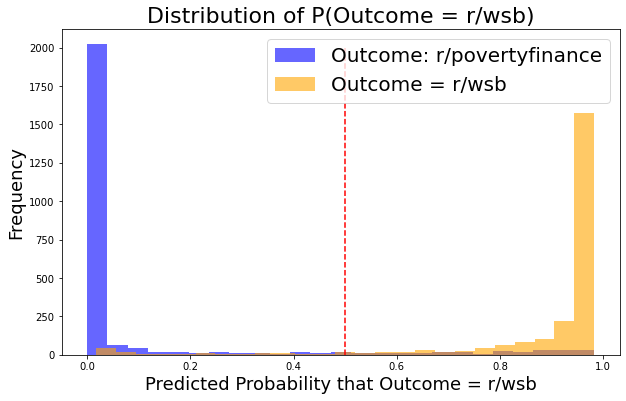

In [172]:
# Plotting two histograms of predict probas
plt.figure(figsize = (10,6))

plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome: r/povertyfinance')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = r/wsb')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 2000,
           color = 'r',
           linestyle = '--')

plt.title('Distribution of P(Outcome = r/wsb)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = r/wsb', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

### Analysis

The probabilty distribution for r/povertyfinance and r/investing shows that misclassifications happen when the probabilities overlap. We can see that there are not many misclassifications. Our default threshold is at 0.5. We will move on to plot the roc_auc curve for further analysis and see if we can optimize this threshold.

0.9754062228234776

Text(0, 0.5, 'True Positve')

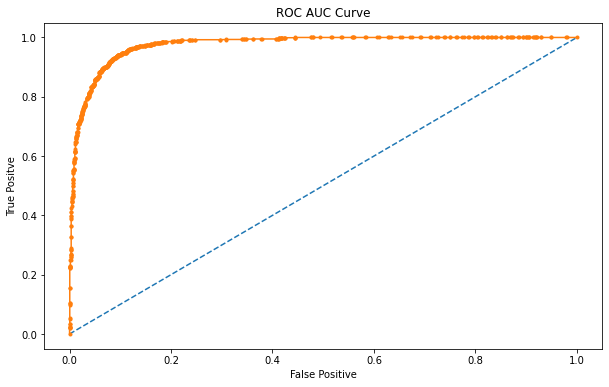

In [173]:
# Calculating roc_auc score
lr_auc = roc_auc_score(y_test, pred_df['pred_probs'])
display(lr_auc)

# plotting roc auc curve
fpr, tpr, thresholds = roc_curve(y_test, pred_df['pred_probs'])

plt.figure(figsize = (10,6))

plt.plot([0,1], [0,1], linestyle='--', label='Base')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.title('ROC AUC Curve')
plt.xlabel('False Positive')
plt.ylabel('True Positve')

In [174]:
# Finding the max difference between true positive and false positive to find best threshold
diff = tpr - fpr
max_index = argmax(diff)
best_thresh = thresholds[max_index]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.499842


### Analysis
The optimal threshold is when we maximize true positive rate and lower false positive rate <sup> 4 </sup>. Here, we have found our optimal threshold to be 49.9%. However, though this is the best threshold for accuracy, it may not be the best threshold from the company's point of view. This is especially so when the company is highly profit driven and is willing to accept more false positive (lower capital individuals introduced to riskier high growth investments) to minimize false negative (higher net worth individuals looking to take high growth investments introduced to basic investment plans). Hence, we will create a function to find the greatest profit for the company. Though we usually will work with our finance division to get the estimates, we will now  come up with our own estimates for each situation.

true positive: + $ 2000 (Risk loving investor sign high growth plan)

true negative: + $ 1000 (low capital investor sign basic plan)

false positive: + $ 500 (low capital investor sign high growth plan)

false negative: + $ 250 (Risk loving investor sign basic plan)

note: the gain is smaller for false predictions as most of them will reject the proposal due to mismatch

In [193]:
# defining calculation to calculate the cost for each threshold

def profit_function(tn, fp, fn, tp):
    pro = 0
    
    pro += (tp * 2000)
    pro += (tn * 1000)
    pro += (fp * 500)
    pro += (fn * 250) 
    
    return pro

In [194]:
# creating list to store results to put into df
profit = []
tns = []
fps = []
fns = []
tps = []

# running through the different thresholds

for threshold in thresholds:
    y_pred_with_threshold = (error_analysis_df['pred_probs'] >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_with_threshold).ravel()
    profit.append(profit_function(tn, fp, fn, tp))
    tns.append(tn), fps.append(fp), fns.append(fn), tps.append(tp)
    
profit_df = pd.DataFrame({'threshold':thresholds, 'profit':profit, 'tn':tns, 'fp':fps, 'fn':fns, 'tp':tps})
        
max_profit = profit_df['profit'].max()
threshold = profit_df[profit_df['profit']==max_profit].iloc[0]['threshold']

In [195]:
profit_df[profit_df['profit']==max_profit].iloc[0]

threshold         0.070
profit      6953250.000
tn             2082.000
fp              415.000
fn               47.000
tp             2326.000
Name: 508, dtype: float64

### Analysis

We can see that our optimal threshold is 7%. This is the threshold the company will accept in order to minimize false negative and gain max profits.

In [202]:
### Restating final model

lr_final = LogisticRegression(C = 1, penalty = 'l2')
cvec_final = CountVectorizer(tokenizer=StringTokenizer(), stop_words = stop_words_base, 
                                      max_features = 2000, ngram_range = (1,1))

pipe = Pipeline(
        [
        ('cvec', cvec_final),
        ('lr', lr_final)
    ]
    )

pipe.fit(x_train,y_train)

# part 2 of our model

x_train_df = pd.DataFrame(x_train)
x_test_df = pd.DataFrame(x_test)

# storing probabilitiy numeric figure for use later
x_train_df['proba'] = pipe.predict_proba(x_train)[:,1]
x_test_df['proba'] = pipe.predict_proba(x_test)[:,1]

# extracting number of comments
x_train_df['num_comments'] = combined_df.loc[x_train_df.index]['num_comments']
x_test_df['num_comments'] = combined_df.loc[x_test_df.index]['num_comments']

x_train_df2 = x_train_df[['proba','num_comments']]
x_test_df2 = x_test_df[['proba','num_comments']]

# instantiating model 2 best params
final_lr_2 = LogisticRegression(penalty = 'l2', C=0.1)

# final train and fit
final_lr_2.fit(x_train_df2,y_train)

In [204]:
#storing predict proba for confusion matrix
pred_proba = [i[1] for i in final_lr_2.predict_proba(x_test_df2)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

# creating prediction column with final threshold
pred_df['final_predict'] = np.where(pred_df['pred_probs']>=0.07,1,0)
pred_df.head()

true_values  pred_probs  final_predict
5621             1       0.873              1
4765             1       0.963              1
2877             1       0.971              1
14972            0       0.002              0
19361            0       0.000              0

In [208]:
#creating column for pred probabilities for train set
train_proba = [i[1] for i in final_lr_2.predict_proba(x_train_df2)]
pred_train_df = pd.DataFrame({'true_values': y_train,
                        'pred_probs':train_proba})

# creating train prediction column with final threshold
pred_train_df['final_predict'] = np.where(pred_train_df['pred_probs']>=0.07,1,0)
pred_train_df.head()

true_values  pred_probs  final_predict
17747            0       0.001              0
13710            0       0.001              0
17587            0       0.001              0
7051             1       0.970              1
16997            0       0.000              0

In [210]:
#printing out final model metrics

results = {}
results['model'] = 'cvec logreg + logreg'
results['train'] = len(pred_train_df[pred_train_df['true_values']==pred_train_df['final_predict']])/len(pred_train_df)
results['test'] = len(pred_df[pred_df['true_values']==pred_df['final_predict']])/len(pred_df)

predictions = pred_df['final_predict']

results['roc_auc_score'] = roc_auc_score(y_test,predictions)
results['precision'] = precision_score(y_test,predictions)
results['recall'] = recall_score(y_test,predictions)
results['f_score'] = f1_score(y_test,predictions)

print ('## METRICS ##')

display(results)

tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()

print(f'True Negatives: {tn}')
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')

## METRICS ##


{'model': 'cvec logreg + logreg',
 'train': 0.9245722108145106,
 'test': 0.9049281314168378,
 'roc_auc_score': 0.9067865003111193,
 'precision': 0.8485401459854015,
 'recall': 0.9797724399494311,
 'f_score': 0.9094465088988851}

True Negatives: 2082
True Positives: 2325
False Positives: 415
False Negatives: 48


### Conclusion and Recommendations

**Problem Statement**

As a data Scientist working for a financial advisory company, we have been tasked to classify investors who require basic savings/investment plans from higher net worth individuals who prefer higher growth investment plans. 

**General Summary**

- We observe that individuals who are financially challenged are more desperate in seeking help. Our model thus pegs words such as 'help' and 'need' to them. They are also more inclined to use more common everyday financial terms, such as 'credit card' and 'bank'.


- Building on our first point, as users who are financially challenged tend to seek help, their posts will naturally attract more comments from people giving advice etc. This thus allows us to incorporate numerical features such as number of comments into the model.


- Individuals who have higher capital and prefer high risk high growth investment strategies tend to be more analytical in their post. Discussions can commonly about when to enter or exit the stock market. Moreover, they usually will use new finance terms relating to the latest trends, such as 'moon' for 'to the moon' where stock prices rise.


- We have built a model which utilizes Count Vectorizer for bag of words model, logistic regression to find the probabilities of each word belonging to r/wallstreetbets, and then putting the probabilities together with number of comments into another logistic regression model. We chose to accept more false positives in exchange for false negatives, and have achieved a final accuracy score of 90.5%, with recall score 97.9%.


**Model limitations**

- As high growth high risk investors like to use new finance lingo, the company will have to constantly ensure that features are updated and not outdated. For example, words like 'Russia' and 'moon' plays an important role in classifying posts now due to the volatility caused by the crisis, but may not be in the future.


- The model may not be able to predict the right subreddit when keywords are taken out of context. For example, individuals may complain about their financial situation in r/povertyfinance as they may have lost their money in 'stocks', but the model will classify it as individuals with high income and can spend on high growth investment plans.


-  The model is not able to fully analyse non-ASCII characters, such as emojis and foreign characters. Though we removed them in our model, if possible, they should also be considered data observations too. For example, emojis like 🙃 is a good indicator that someone is being sarcastic. Perhaps we could use a tool like vader to process these non-ASCII characters. We could also manually train our model to understand these characters, though that will require a significant amount of time.

**Future Works**

- We can explore using other models and tools. For example, instead of classifying posts using frequency of words, we can consider using word similarities/analogies such as word2vec. We can also consider using stemming instead of lemmatizing for our words. Other classifiers such as K-Nearest Neighbors classifier and boosting algorithms can also be explored.


- We notice how vader sentiment analysis is not able to read the sentiment of finance terms such as bull and bear. We can thus explore using a sentiment dictionary more relevant for finance. We can even train our own sentiment library for the model.


- We can also expand ngram words to include 3 or more words. This will allow us to find greater synergies and allow our model to encapsulate the context of the post better.

### Outside Research

1. https://www.forbes.com/sites/georgeschultze/2021/06/15/are-the-apes-now-running-wall-street/?sh=36860ee35e88
    
    Summary: Understood more about the term apes, which is finance lingo for banding together to buy a stock.
    
    
    
2. https://www.fidelity.com/Learning-center/trading-investing/ukraine-russia

   Summary: Understood that the Ukraine crisis caused volatility in the markets, thus resulting in much discussion among investors
   
   
3. https://www.vox.com/the-goods/22249458/gamestop-stock-wallstreetbets-reddit-citron

    Summary: Read up on the backstory of Gamestop and understood it's presence in forums.
    
    
4. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5147524/
    
    Summary: Understood how to find the optimal threshold estimation for ROC-AUC curve for a binary classifier using game theory.
    
    
5. https://www.codeproject.com/Articles/5269447/Pros-and-Cons-of-NLTK-Sentiment-Analysis-with-VADE
    
    Summary: The article talks about the weaknesses of VADER sentiment analyzer like how it is unable to understand jargon.